<a href="https://colab.research.google.com/github/eclipseeyo/practiceML/blob/main/TimeSeries_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Машинное обучение для временных рядов

План семинара:

1. Обучение моделей
2. ETNA для построения прогнозов
3. Учет экзогенных факторов

In [ ]:
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.0 MB/s eta 0:00:00


In [ ]:

import warnings
warnings.filterwarnings('ignore')

from catboost import CatBoostRegressor

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm.notebook import tqdm

%config InlineBackend.figure_format = 'svg'
from pylab import rcParams
rcParams['figure.figsize'] = 7, 5

### Предобработка временного ряда  <a name="preprocess">

Возьмем датасет, в котором будет присутвовать переменная, изменяющася во времени. Давайте сегодня попробуем поработать с набором данных по среднесуточной дневной температуре в городе Дели, собранном за несколько лет. Подробнее почитать про датасет можно на [Kaggle](https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data)

Датасет сразу разбит на две части - train и test, но будем использовать для обучения и валидации моделей только train, оставив test как отложенную выборку для проверки качества.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/DailyDelhiClimateTrain.csv')

print(f"Дни с {min(df.date)} по {max(df.date)}, всего {df.date.nunique()} дней.")
df.head()

Дни с 2013-01-01 по 2016-12-31, всего 1461 дней.


,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [ ]:
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')

df = df[['date','meantemp']].set_index('date')

df.head()

,meantemp
date,
2013-01-01,10.000000
2013-01-02,7.400000
2013-01-03,7.166667
2013-01-04,8.666667
2013-01-05,6.000000


<Axes: xlabel='date'>

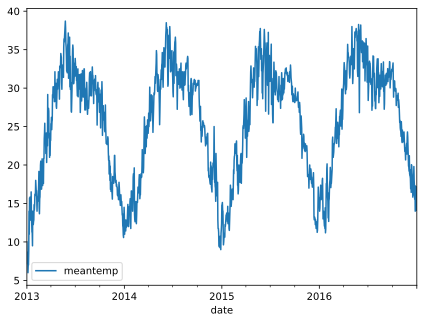

In [ ]:
df.plot()

### Генерация признаков <a name="features">

Основные подходы по генерации признаков:

* лаговые признаки (lags) - значения ряда в предыдущие моменты времени

* агрегации (среднее значение ряда по часу, дню, месяцу и так далее; медиана, дисперсия и так далее)


Напишем функцию, которая возвращает словарь, где ключами являются уникальные категории признака cat_feature, а значениями - средние по real_feature.

In [ ]:
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

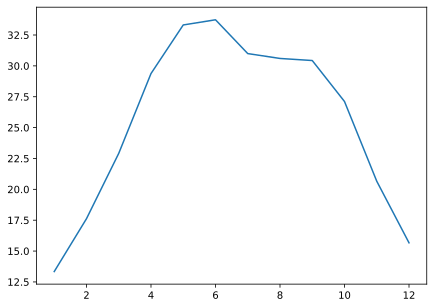

In [ ]:
df["month"] = df.index.month

d = code_mean(df, "month", "meantemp")

plt.plot(d.keys(), d.values())

Можно это удобно обернуть в функцию и заменить исходные признаки на их среднее как один из вариантов препроцессинга, а также - добавить значения целевой переменной с разной длинной временного лага.

В функции мы:

1) Разбиваем данные на тренировочную и тестовую части

2) Генерируем лаговые признаки

3) Генерируем агрегированные признаки

In [ ]:
def preprocess_data(data, lag_start=5, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())

    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data) * (1 - test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data.meantemp.shift(i)

    data["weekday"] = data.index.weekday
#    data["week"] = data.index.week
    data["month"] = data.index.month
    data["year"] = data.index.year

    # считаем средние только по тренировочной части, чтобы избежать лика (data leak)
    data["weekday_average"] = list(map(code_mean(data[:test_index], "weekday", "meantemp").get, data.weekday))
#    data["week_average"] = list(map(code_mean(data[:test_index], "week", "meantemp").get, data.week))
    data["month_average"] = list(map(code_mean(data[:test_index], "month", "meantemp").get, data.month))
    data["year_average"] = list(map(code_mean(data[:test_index], "year", "meantemp").get, data.year))

    # выкидываем закодированные средними признаки
    data.drop(["weekday", 'month', 'year'], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["meantemp"], axis=1)
    y_train = data.loc[:test_index]["meantemp"]
    X_test = data.loc[test_index:].drop(["meantemp"], axis=1)
    y_test = data.loc[test_index:]["meantemp"]

    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = preprocess_data(df, test_size=0.3, lag_start=3, lag_end=10)

X_train.head()

,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,weekday_average,month_average,year_average
0,7.000000,7.000000,6.000000,8.666667,7.166667,7.400000,10.000000,25.440460,12.738377,24.791494
1,8.857143,7.000000,7.000000,6.000000,8.666667,7.166667,7.400000,25.372054,12.738377,24.791494
2,14.000000,8.857143,7.000000,7.000000,6.000000,8.666667,7.166667,25.331414,12.738377,24.791494
3,11.000000,14.000000,8.857143,7.000000,7.000000,6.000000,8.666667,25.202210,12.738377,24.791494
4,15.714286,11.000000,14.000000,8.857143,7.000000,7.000000,6.000000,25.499234,12.738377,24.791494


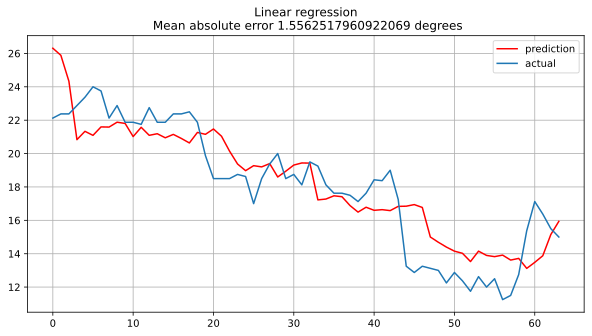

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

preds = lr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute error {mean_absolute_error(preds, y_test)} degrees");

In [ ]:
coef_table = pd.DataFrame({'features' : list(X_train.columns), 'weights' : lr.coef_})

coef_table.sort_values(by='weights')

,features,weights
6,lag_9,-0.017693
4,lag_7,-0.008115
5,lag_8,0.016994
2,lag_5,0.027257
3,lag_6,0.038893
9,year_average,0.069241
1,lag_4,0.096807
0,lag_3,0.377216
8,month_average,0.459795
7,weekday_average,1.371299


## DecisionTree

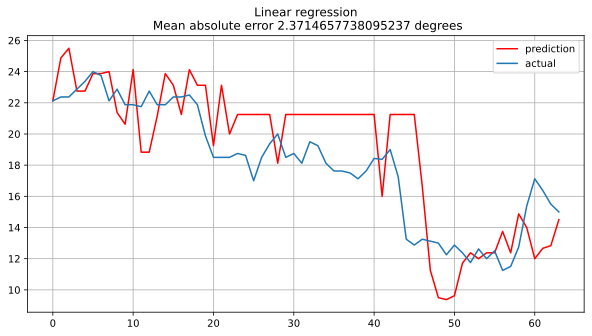

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
preds = dt.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute error {mean_absolute_error(preds, y_test)} degrees");

## RandomForest

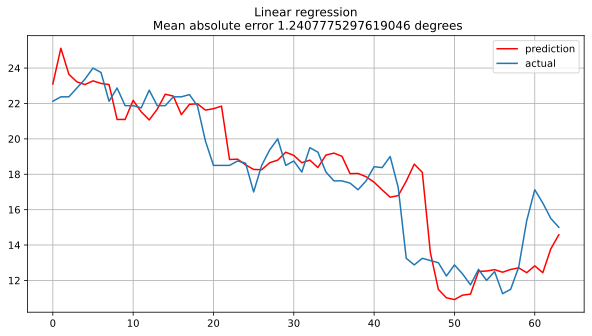

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
preds = rf.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute error {mean_absolute_error(preds, y_test)} degrees");

## CatBoost

Learning rate set to 0.109355
0:	learn: 6.6174733	total: 59.3ms	remaining: 17.7s
1:	learn: 6.0331380	total: 69.9ms	remaining: 10.4s
2:	learn: 5.5098821	total: 88ms	remaining: 8.71s
3:	learn: 5.0551155	total: 102ms	remaining: 7.55s
4:	learn: 4.6496495	total: 110ms	remaining: 6.5s
5:	learn: 4.2958289	total: 118ms	remaining: 5.76s
6:	learn: 3.9925983	total: 128ms	remaining: 5.34s
7:	learn: 3.7388168	total: 143ms	remaining: 5.21s
8:	learn: 3.4900130	total: 147ms	remaining: 4.74s
9:	learn: 3.2789233	total: 160ms	remaining: 4.65s
10:	learn: 3.1042190	total: 164ms	remaining: 4.32s
11:	learn: 2.9457228	total: 175ms	remaining: 4.21s
12:	learn: 2.8083740	total: 182ms	remaining: 4.02s
13:	learn: 2.6961076	total: 192ms	remaining: 3.93s
14:	learn: 2.6034971	total: 205ms	remaining: 3.89s
15:	learn: 2.5219267	total: 211ms	remaining: 3.74s
16:	learn: 2.4522084	total: 213ms	remaining: 3.54s
17:	learn: 2.3889236	total: 218ms	remaining: 3.42s
18:	learn: 2.3407885	total: 220ms	remaining: 3.26s
19:	learn: 

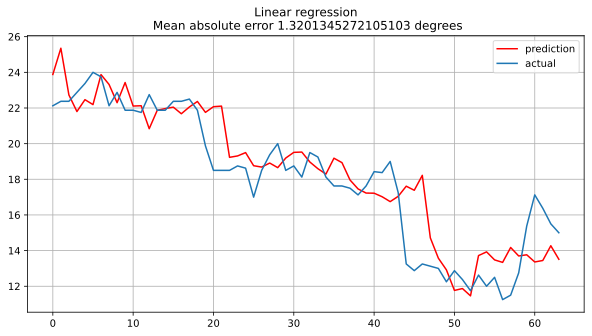

In [ ]:
cb = CatBoostRegressor(n_estimators=300)
cb.fit(X_train, y_train)
preds = cb.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute error {mean_absolute_error(preds, y_test)} degrees");

In [ ]:
coef_table = pd.DataFrame({'features' : list(X_train.columns), 'weights' : cb.feature_importances_})

coef_table.sort_values(by='weights')

,features,weights
7,weekday_average,1.881659
9,year_average,2.808518
5,lag_8,5.971401
6,lag_9,7.934825
2,lag_5,8.789507
3,lag_6,10.718071
4,lag_7,11.321736
1,lag_4,12.442181
0,lag_3,17.748921
8,month_average,20.383182


## Библиотеки для работы с временными рядами
    
Для работы с временными рядами существует несколько хороших библиотек. Мы немного посмотрим на библиотеку ETNA, но есть и другие.
    
Среди них: библиотека от Facebook [Prophet](https://github.com/facebook/prophet), [tsfresh](https://github.com/blue-yonder/tsfresh), [darts](https://github.com/unit8co/darts) и другие (можно посмотреть на github).

Источники:

1. Пост на Хабре от ODS https://habr.com/ru/company/ods/blog/327242/
2. Онлайн-учебник курса по продвинутому статистическому прогнозированию университета Duke  https://people.duke.edu/~rnau/411home.htm

# ETNA (от Тинькофф)

Первая общедоступная версия библиотеки появилась в сентябре 2021 г.

In [ ]:
!pip install etna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.2/422.2 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.1/354.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/DailyDelhiClimateTrain.csv')

df = df[['date','meantemp']]

Приведем данные к формату, с которым работает ETNA:

* колонка `timestamp` - время в формате datetime
* колонка `target` - целевая переменная (прогнозируемый ряд)
* колонка `segment` - `main` в случае, если целевая переменная - это один ряд

In [ ]:
df["timestamp"] = pd.to_datetime(df["date"])
df["target"] = df["meantemp"]
df.drop(columns=["date", "meantemp"], inplace=True)
df["segment"] = "main"

df.head()

,timestamp,target,segment
0,2013-01-01,10.000000,main
1,2013-01-02,7.400000,main
2,2013-01-03,7.166667,main
3,2013-01-04,8.666667,main
4,2013-01-05,6.000000,main


В ETNA есть специальный класс для работы с временными рядами - TSDataset, приведем наши данные к этому формату.

In [ ]:
from etna.datasets.tsdataset import TSDataset

df = TSDataset.to_dataset(df)
df.head()

segment,main
feature,target
timestamp,
2013-01-01,10.000000
2013-01-02,7.400000
2013-01-03,7.166667
2013-01-04,8.666667
2013-01-05,6.000000


Укажем временной шаг (дни).

In [ ]:
ts = TSDataset(df, freq="D")

ts.head()

segment,main
feature,target
timestamp,
2013-01-01,10.000000
2013-01-02,7.400000
2013-01-03,7.166667
2013-01-04,8.666667
2013-01-05,6.000000


In [ ]:
ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 1
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
         start_timestamp end_timestamp  length  num_missing
segments                                                   
main          2013-01-01    2016-12-31    1461            0


In [ ]:
ts.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
main,2013-01-01,2016-12-31,1461,0,1,0,0,0,D


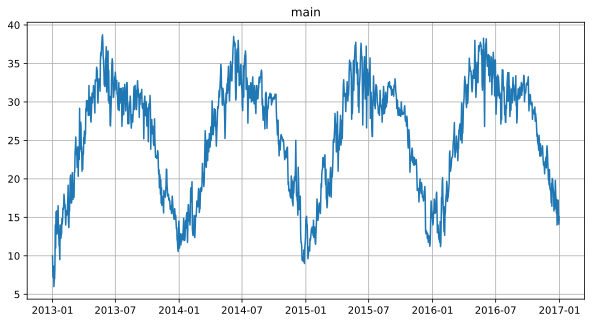

In [ ]:
ts.plot()

Разбиваем данные на тренировочную и тестовую части

In [ ]:
train_ts, test_ts = ts.train_test_split(
    train_start="2013-01-01",
    train_end="2015-12-31",
    test_start="2016-01-01",
    test_end="2016-12-31",
)

В библиотеке ETNA реализовано множество самых разных моделей - от классической SARIMAX до нейронных сетей.

Обучим самую простую модель из ETNA - NaiveModel.

Наивная модель предсказывает текущее значение, равное значению ряда несколько периодов назад (lag):

$$y_t = y_{t-lag}$$

In [ ]:
HORIZON = 366 # горизонт прогнозирования

from etna.models import NaiveModel, CatBoostMultiSegmentModel, LinearPerSegmentModel, SARIMAXModel

# Fit the model
model1 = NaiveModel(lag=5)

model1.fit(train_ts)

# Make the forecast
future_ts = train_ts.make_future(future_steps=HORIZON, tail_steps=model1.context_size)

forecast_ts = model1.forecast(future_ts, prediction_size=HORIZON)

ImportError: cannot import name 'Literal' from 'statsmodels.compat.python' (/usr/local/lib/python3.10/dist-packages/statsmodels/compat/python.py)

In [ ]:
from etna.metrics import SMAPE

smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 50.067909843390055}

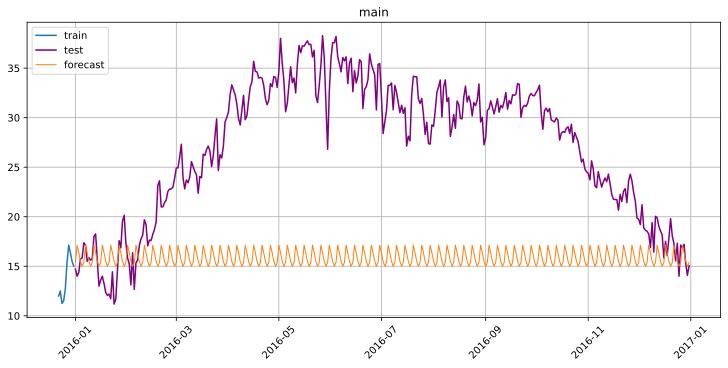

In [ ]:
from etna.analysis import plot_forecast

plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

### Prophet (от Facebook)

Библиотека Prophet использует аддитивную модель для прогнозирования временных рядов. Аддитивная модель предполагает, что значение временного ряда можно разложить на несколько компонент, таких как тренд, сезонность, праздничные эффекты и остатки.

Модель Prophet выражается следующим уравнением:

$$y_t = g_t + s_t + h_t + e_t,$$

где:

* $g_t$ представляет тренд, моделирующий нелинейное изменение значения временного ряда во времени

* $s_t$ представляет сезонность, учитывающую повторяющиеся паттерны или циклы во временном ряду

* $h_t$ представляет праздничные эффекты, учитывающие влияние праздников и событий на временной ряд

* $e_t$ представляет остатки, которые предполагаются нормально распределенными шумами вокруг модели

Тренд моделируется с использованием гибкой линейной модели, которая может аппроксимировать нелинейные изменения во временном ряду. Сезонность моделируется с помощью фурье-рядов, позволяющих учесть сезонные колебания с различными периодами. Праздничные эффекты моделируются путем добавления индикаторов праздников в модель.

Prophet также автоматически настраивает гиперпараметры модели, такие как гибкость тренда и сезонности, а также влияние праздников. Он также предоставляет возможность пользователю настраивать некоторые параметры, такие как сезонность, шум и другие.

In [ ]:
from etna.models import ProphetModel

model2 = ProphetModel()

model2.fit(train_ts)

# Make the forecast
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model2.forecast(future_ts)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5u7sw88s/5pv24khu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5u7sw88s/bj8c8v23.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58005', 'data', 'file=/tmp/tmp5u7sw88s/5pv24khu.json', 'init=/tmp/tmp5u7sw88s/bj8c8v23.json', 'output', 'file=/tmp/tmp5u7sw88s/prophet_model1kljocnk/prophet_model-20230804162552.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:25:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:25:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 10.532028749602292}

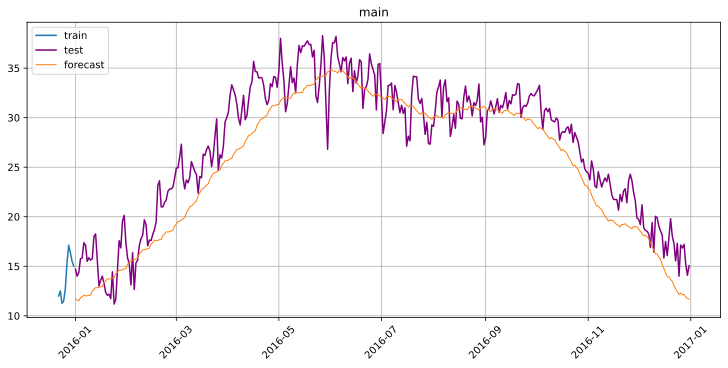

In [ ]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

# Pipeline

Для обучения и валидации модели будем использовать сущность `Pipeline`. В целом, использование `Pipeline` позволит ускорить и упростить обучение и тестирование модели. Например, разбиение на тренировочные и тестовые выборки при запуске кросс валидации в таком случае будет производиться автоматически.

`Pipeline` имеет несколько параметров:

* `model` - модель, которая будет обучаться и тестироваться;
* `horizon` - горизонт прогнозирования;
* `transforms` - список преобразований, которые нужно применить к данным.

Ещё одним достоинством использования пайплайна является автоматическое прямое и обратное преобразование данных, следовательно, о согласованности данных можно не беспокоиться. Кросс валидацию на исторических данных можно запустить с помощью метода `backtest`.

In [ ]:
from etna.pipeline import Pipeline
from etna.metrics import MAE, SMAPE
from etna.transforms import STLTransform, LagTransform, MeanSegmentEncoderTransform

pipe = Pipeline(
    transforms=[
        STLTransform(in_column="target", period=7, model="arima"),
        LagTransform(in_column="target", lags=list(range(3, 10, 1))),
    ],
    model=LinearPerSegmentModel(),
    horizon=3
)

## Backtest

Backtest - это кросс-валидация на временных рядах.

In [ ]:
metrics, forecast, _ = pipe.backtest(
    ts=ts, metrics=[MAE(), SMAPE()], n_folds=5)

metrics

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Do

,segment,MAE,SMAPE,fold_number
0,main,0.956865,5.492141,0
0,main,1.679161,9.454322,1
0,main,1.986150,12.403313,2
0,main,0.500228,2.888707,3
0,main,0.352171,2.309867,4


In [ ]:
mae_value = metrics.mean().to_dict()["MAE"]

mae_value

1.094914868018162

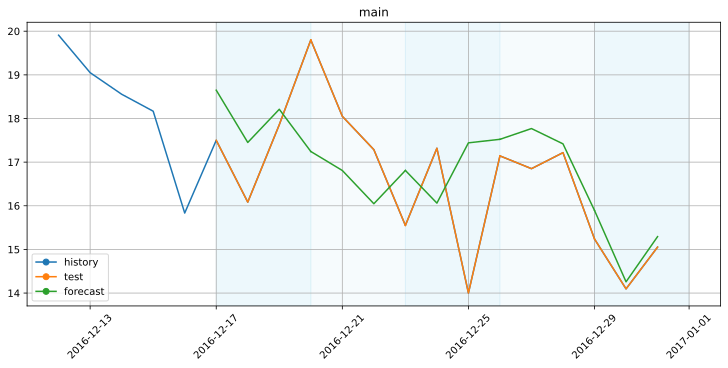

In [ ]:
from etna.analysis import plot_backtest

plot_backtest(forecast_df=forecast, ts=ts, history_len=5)

In [ ]:
pipe2 = Pipeline(
    transforms=[
        STLTransform(in_column="target", period=7, model="arima"),
        LagTransform(in_column="target", lags=list(range(3, 10, 1))),
    ],
    model=CatBoostMultiSegmentModel(n_estimators=1000, learning_rate=0.01),
    horizon=3
)

In [ ]:
metrics, forecast, _ = pipe2.backtest(
    ts=ts, metrics=[MAE(), SMAPE()], n_folds=5)

metrics

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    6.4s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    8.0s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    9.6s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    9.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Do

,segment,MAE,SMAPE,fold_number
0,main,0.606679,3.509500,0
0,main,1.688889,9.534459,1
0,main,2.000959,12.491365,2
0,main,0.399407,2.309858,3
0,main,0.238378,1.558969,4


In [ ]:
mae_value = metrics.mean().to_dict()["MAE"]

mae_value

0.9868626308337773

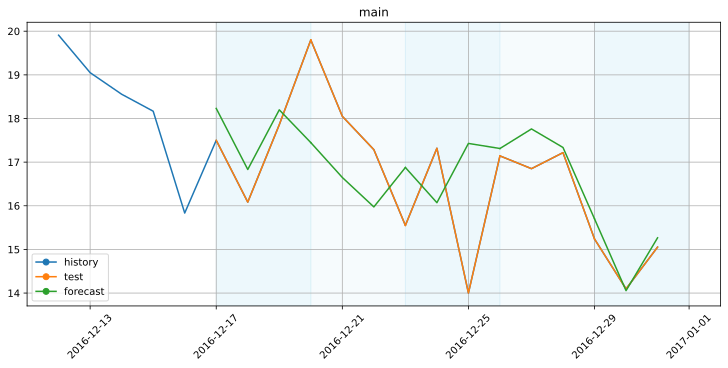

In [ ]:
plot_backtest(forecast_df=forecast, ts=ts, history_len=5)

Примеры ноутбуков с использованием ETNA:

* [tutorial из документации](https://github.com/tinkoff-ai/etna/blob/master/examples/get_started.ipynb)

* [семинар с курса "Прикладные задачи машинного обучения" в ВШЭ](https://github.com/hse-ds/iad-applied-ds/blob/master/2023/seminars/sem07_ts2/sem07_ts2.ipynb)

## Учет экзогенных факторов

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/DailyDelhiClimateTrain.csv')

df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')

df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [ ]:
df = df[['date','meantemp','meanpressure']].set_index('date')

In [ ]:
def preprocess_data_exog(data, lag_start=5, lag_end=20, test_size=0.15):

    exog = "meanpressure"

    data = pd.DataFrame(data.copy())

    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data) * (1 - test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data.meantemp.shift(i)
        data[f"lag_exog_{i}"] = data[exog].shift(i)

    data["weekday"] = data.index.weekday
    data["week"] = data.index.week
    data["month"] = data.index.month
    data["year"] = data.index.year

    # считаем средние только по тренировочной части, чтобы избежать лика (data leak)
    data["weekday_average"] = list(map(code_mean(data[:test_index], "weekday", "meantemp").get, data.weekday))
    data["week_average"] = list(map(code_mean(data[:test_index], "week", "meantemp").get, data.week))
    data["month_average"] = list(map(code_mean(data[:test_index], "month", "meantemp").get, data.month))
    data["year_average"] = list(map(code_mean(data[:test_index], "year", "meantemp").get, data.year))

    data["weekday_average_exog"] = list(map(code_mean(data[:test_index], "weekday", exog).get, data.weekday))
    data["week_average_exog"] = list(map(code_mean(data[:test_index], "week", exog).get, data.week))
    data["month_average_exog"] = list(map(code_mean(data[:test_index], "month", exog).get, data.month))
    data["year_average_exog"] = list(map(code_mean(data[:test_index], "year", exog).get, data.year))

    # выкидываем закодированные средними признаки
    data.drop(["weekday", "week", "month", "year", exog], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["meantemp"], axis=1)
    y_train = data.loc[:test_index]["meantemp"]
    X_test = data.loc[test_index:].drop(["meantemp"], axis=1)
    y_test = data.loc[test_index:]["meantemp"]

    return X_train, X_test, y_train, y_test

In [ ]:
X_train_big, X_test_big, y_train, y_test = preprocess_data_exog(df, test_size=0.3, lag_start=3, lag_end=10)

X_train_big.head()

,lag_3,lag_exog_3,lag_4,lag_exog_4,lag_5,lag_exog_5,lag_6,lag_exog_6,lag_7,lag_exog_7,...,lag_9,lag_exog_9,weekday_average,week_average,month_average,year_average,weekday_average_exog,week_average_exog,month_average_exog,year_average_exog
0,7.000000,1020.000000,7.000000,1018.000000,6.000000,1016.500000,8.666667,1017.166667,7.166667,1018.666667,...,10.000000,1015.666667,25.440460,11.925454,12.738377,24.791494,1007.715550,1017.573980,1018.552483,1007.642172
1,8.857143,1018.714286,7.000000,1020.000000,7.000000,1018.000000,6.000000,1016.500000,8.666667,1017.166667,...,7.400000,1017.800000,25.372054,11.925454,12.738377,24.791494,1007.542990,1017.573980,1018.552483,1007.642172
2,14.000000,1017.000000,8.857143,1018.714286,7.000000,1020.000000,7.000000,1018.000000,6.000000,1016.500000,...,7.166667,1018.666667,25.331414,11.925454,12.738377,24.791494,1007.585645,1017.573980,1018.552483,1007.642172
3,11.000000,1015.666667,14.000000,1017.000000,8.857143,1018.714286,7.000000,1020.000000,7.000000,1018.000000,...,8.666667,1017.166667,25.202210,11.925454,12.738377,24.791494,1007.803264,1017.573980,1018.552483,1007.642172
4,15.714286,1016.142857,11.000000,1015.666667,14.000000,1017.000000,8.857143,1018.714286,7.000000,1020.000000,...,6.000000,1016.500000,25.499234,13.067177,12.738377,24.791494,1007.899013,1018.442744,1018.552483,1007.642172


Заново обучим линейную регрессию на исходных данных (чтобы затем сравнить)

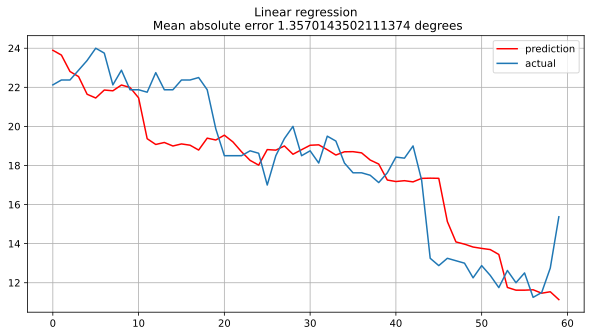

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute error {mean_absolute_error(preds, y_test)} degrees");

Теперь обучим модель на данных с учетом экзогенных факторов

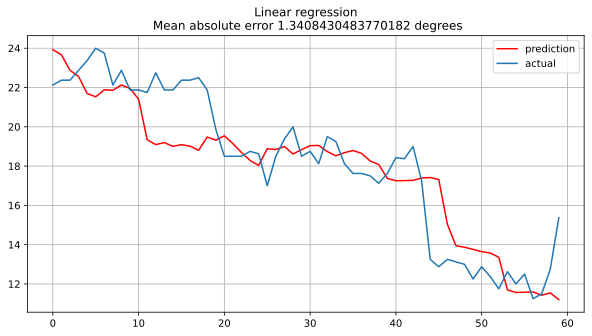

In [ ]:
lr = LinearRegression()
lr.fit(X_train_big, y_train)
preds = lr.predict(X_test_big)

plt.figure(figsize=(10, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute error {mean_absolute_error(preds, y_test)} degrees");

In [ ]:
coef_table = pd.DataFrame({'features' : list(X_train_big.columns), 'weights' : lr.coef_})

coef_table.sort_values(by='weights')

# Курсы сообщества AI Education

### Интенсивы

[Линейные модели и их презентация](https://stepik.org/a/177215)  (**с 9 августа**)

В курсе вы не только разберете теоретическую сторону предмета, но и узнаете как использовать модели на практике:
  * Будете оценивать качество моделей регрессии и классификации
  * Проходить все этапы задачи ML: от разведочного анализа до получения прогноза и его интерпретации
  * Cтроить интерактивные дашборды при помощи библиотеки Streamlit
  * Cоздавать веб-сервисы с использованием фреймворка FastApi


**Программа**
*   Задача регрессии. Линейная регрессия
*   ООП в Python (классы, наследование, декораторы)
*   Асинхронный Python
*   Метрики качества регрессии и интерпретация моделей
*   SQL (PostgreSQL)
*   Работа с SQLAlchemy в Python
*   Линейная классификация. Логистическая регрессия
*   Основы работы с FastApi
*   Интерпретация моделей классификации
*   Фреймоворк Streamlit
*   Подведение итогов

[Разведочный анализ данных](https://stepik.org/a/177213) (**в записи**)

На интенсиве вы познакомитесь с основными и продвинутыми подходами анализа данных:
  * Научитесь исследовать данные при помощи современных библиотек (NumPy, Pandas, Polars, Matplotlib, Seaborn)
  * Обучите свою первую модель машинного обучения
  * Построите интерактивный дашборд при помощи инструмента ExplainerDashboard
  * Начнете использовать такие инструменты разработчика как Git и Docker

В каждом интенсиве по 11 вебинаров (4 по анализу данных / 6 по разработке / финальный с подведением итогов).

### Курсы

[Практический Machine Learning](https://stepik.org/a/125501)

  * Курс посвящен изучению всех основных задач и подходов в машинном обучении. Курс дает как теорию методов, так и обширную практику.
  * За 16 недель курса вы пройдете путь практически с нуля в машинном обучении до уверенного владения основными алгоритмами и подходами.

[Прикладные задачи машинного обучения](https://stepik.org/a/175967)

* В курсе подробно разобраны следующие темы:

  * построение рекомендательных систем
  * анализ временных рядов
  * продвинутые методы интерпретации ML-моделей
  * AutoML

* Курс находится в процессе наполнения, в нем будут появляться новые актуальные и прикладные в ML-темы.